In [26]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 40

In [3]:
#load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
        'rice/rice_leaf_diseases',
        shuffle=True,
        image_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE
)

Found 2872 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names

In [5]:
len(dataset)

90

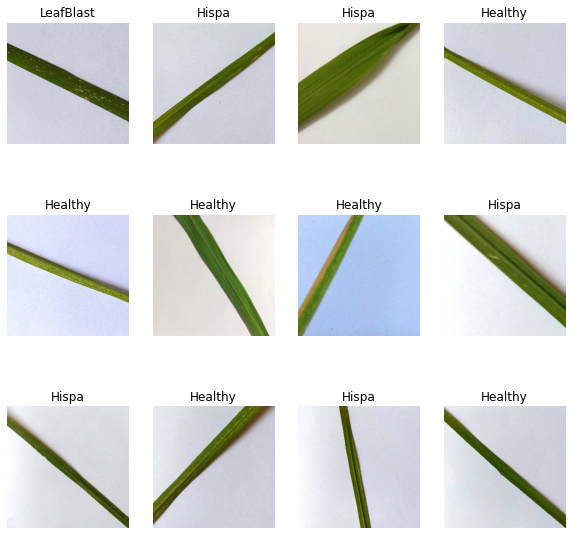

In [6]:
plt.figure(figsize=(10,10)) #increase image area to 10x10
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])#display title
        plt.axis("off")

In [7]:
def get_dataset_partition_tf (ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds) #dataset size
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size) #train size converted to intger to avoid float
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [9]:
len(train_ds)

72

In [10]:
len(val_ds)

9

In [11]:
len(test_ds)

9

In [12]:
#cache will read image from disk and keep image in memeory for next iteration. 
#prefetch and cache to optimize our input pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) #buffer_size=tf.data.AUTOTUNE is to allow tf determine the batch size
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
#resize and rescale
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE), #resize new inputs 
    layers.experimental.preprocessing.Rescaling(1.0/255) #scale down RGB
])

In [14]:
#data_augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])


In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape), #google Conv2D for all arguement. 32=no. of layers
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    #flatten into an array of neurons
    layers.Flatten(),
    layers.Dense(64, activation='relu'), #dense layer of 64 neurons
    layers.Dense(n_classes, activation='softmax'), #softmax normalizes the prob of classes.  
])

model.build(input_shape=input_shape)


In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'] #track training process
)

In [18]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/40
72/72 [==============================] - 197s 2s/step - loss: 1.1107 - accuracy: 0.5061 - val_loss: 1.0922 - val_accuracy: 0.4688
Epoch 2/40
72/72 [==============================] - 127s 2s/step - loss: 1.0468 - accuracy: 0.5243 - val_loss: 1.0751 - val_accuracy: 0.4757
Epoch 3/40
72/72 [==============================] - 117s 2s/step - loss: 1.0205 - accuracy: 0.5330 - val_loss: 1.0734 - val_accuracy: 0.4757
Epoch 4/40
72/72 [==============================] - 121s 2s/step - loss: 1.0128 - accuracy: 0.5347 - val_loss: 1.1052 - val_accuracy: 0.4792
Epoch 5/40
72/72 [==============================] - 122s 2s/step - loss: 1.0104 - accuracy: 0.5404 - val_loss: 1.0480 - val_accuracy: 0.4826
Epoch 6/40
72/72 [==============================] - 122s 2s/step - loss: 0.9995 - accuracy: 0.5395 - val_loss: 1.0757 - val_accuracy: 0.4757
Epoch 7/40
72/72 [==============================] - 378s 5s/step - loss: 1.0161 - accuracy: 0.5378 - val_loss: 1.0533 - val_accuracy: 0.4757
Epoch 8/40
72

In [19]:
  scores = model.evaluate(test_ds)

9/9 [==============================] - 55s 294ms/step - loss: 0.5791 - accuracy: 0.7778


In [20]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 72}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

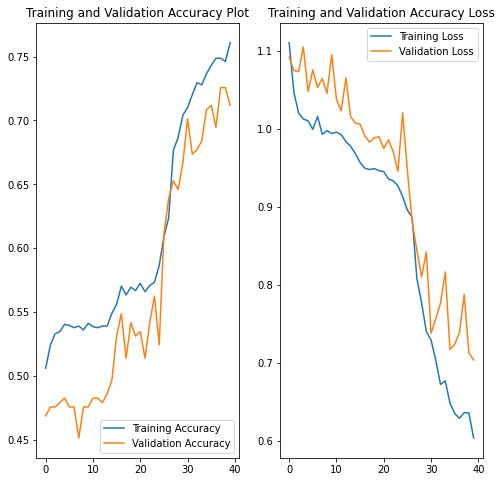

In [23]:
#plotting training and validation accuracy
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label ='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy Plot')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label ='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy Loss')
plt.show()

In [33]:
## save model
save_path = 'Plant Diseasescnn.h5'
model.save(save_path)
## load tensorflow model
model = keras.models.load_model(save_path)

<IPython.core.display.Javascript object>

first image to predict
actual label: Healthy
1/1 [==============================] - 0s 396ms/step
prediction:  Healthy


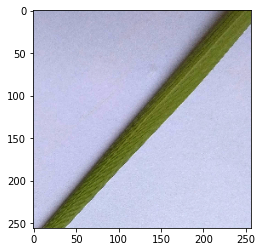

In [36]:
#make a prediction - 1 batch - test_ds

for images_batch, labels_batch in test_ds.take(1):
    #print(images_batch[0].numpy().astype('uint8'))
    #plt.imshow(images_batch[0].numpy().astype('uint8'))
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    #model is ready so call predict function 
    batch_prediction = model.predict(images_batch)
    print("prediction: ", class_names[np.argmax(batch_prediction[0])])